### SVDCNN - Neural Network for Complex Channel Decomposition

#### Document structure:
 - Environment Setup
 - Model Definition: `SVDCNN`
 - Model Testing
 - FLOPs Estimation
 - Custom Loss: `lae_loss`
 - Loss Testing
 - Dataset Class: `ChannelDataset`
 - Data Loading
 - Rule Compliance Summary
 - Suggested Action

#### 1. Environment Setup

- Install and import necessary libraries:
  - PyTorch, NumPy, Matplotlib, Torchvision, etc.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
import os
from sklearn.model_selection import train_test_split

- Set device to CUDA if available

In [2]:
print("Using PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using PyTorch version: 2.3.0+cpu
Using device: cpu


#### 2. Model Definition: `SVDCNN`
- A CNN-based encoder network
- Input `[N_sample, 2, 64, 64]`
- Output:
  - `σ`: Singular values `[N_sample, k]`, complex
  - `U`, `V`: Orthonormal basis matrices  `[N_sample, N, k]`, complex
- Structure:
  - 3-layer convolutional feature extractor
  - Fully connected classifier head
  - Three separate heads for predicting `σ`, `U`, and `V`
- **Uses**:
  - `torch.complex`
  - `torch.norm`

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SVDNet(nn.Module):
    def __init__(self, M=128, N=128, k=64):
        """
        Updated for Round 2: 128x128 matrices, rank 64 approximation
        """
        super(SVDNet, self).__init__()
        self.M = M
        self.N = N
        self.k = k
        
        # === 1. CNN Encoder (Updated for 128x128 input) ===
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=3, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ELU(),
            # nn.Dropout(0.05),
            
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ELU(),
            # nn.Dropout(0.05),
            
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ELU(),
            # nn.Dropout(0.05),
            
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ELU(),
            # nn.Dropout(0.05)
            
        )
        
        self.pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # === 2. Transformer Decoder ===
        d_model = 16 * 8 * 8  # 2048
        
        # Optimal dimension/head ratio between 40 and 50
        num_heads = 16  # 2048 / 40 = 51.2
        
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_model * 4,  # 8192
            dropout=0.1,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        
        # === 3. Output Heads (Updated for rank 64) ===
        self.sigma_head = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ELU(),
            nn.Linear(64, k)
        )
        
        self.U_head = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ELU(),
            nn.Linear(256, k * M * 2)
        )
        
        self.V_head = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ELU(),
            nn.Linear(256, k * N * 2)
        )
        
        # Initialize weights to avoid zero solution
        self._initialize_weights()

    def _initialize_weights(self):
        """Proper initialization to avoid all-zeros local minimum"""
        # Initialize sigma head to produce positive values
        nn.init.kaiming_normal_(self.sigma_head[2].weight)
        nn.init.constant_(self.sigma_head[2].bias, 1.0)  # Start with ones
        
        # Initialize U and V heads
        nn.init.kaiming_normal_(self.U_head[2].weight)
        nn.init.kaiming_normal_(self.V_head[2].weight)
        nn.init.zeros_(self.U_head[2].bias)
        nn.init.zeros_(self.V_head[2].bias)

    def forward(self, x):
        """
        Forward pass for 128x128 matrices and rank 64 approximation
        """
        # x: [B, 2, 128, 128]
        x = self.encoder(x)
        x = self.pool(x)
        
        # Flatten for transformer [B, 1, d_model]
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 1, -1)
        
        # Apply transformer
        x = self.transformer_layer(x)
        
        # Remove sequence dimension
        x = x.squeeze(1)  # [B, d_model]
        
        # Generate singular values (always positive)
        sigma = F.softplus(self.sigma_head(x))  # [B, k]
        
        # Prevent sigma from becoming too small
        sigma = torch.clamp(sigma, min=1e-4)  
        
        # Generate U and V with proper dimensions
        U_flat = self.U_head(x).view(-1, self.M, self.k, 2)  # [B, M, k, 2]
        V_flat = self.V_head(x).view(-1, self.N, self.k, 2)  # [B, N, k, 2]
        
        # === Normalize U and V ===
        # U normalization
        U_norm = torch.norm(U_flat, p=2, dim=1, keepdim=True) + 1e-8
        U_norm = torch.norm(U_norm, p=2, dim=3, keepdim=True) + 1e-8
        U_normalized = U_flat / U_norm
        
        # V normalization
        V_norm = torch.norm(V_flat, p=2, dim=1, keepdim=True) + 1e-8
        V_norm = torch.norm(V_norm, p=2, dim=3, keepdim=True) + 1e-8
        V_normalized = V_flat / V_norm
        
        return sigma, U_normalized, V_normalized

- Model Testing (Dry Run)
    - Dummy input: random tensor
    - Forward pass through model
    - Check output shapes
    - Assertions to validate output dimensions

In [4]:
# Test with proper Round 2 dimensions
model = SVDNet().to(device)
dummy_input = torch.randn(32, 128, 128, 2).to(device)  # batch of 32
dummy_input = dummy_input.permute(0, 3, 1, 2)  # → [B, 2, 128, 128]

with torch.no_grad():
    sigma, U, V = model(dummy_input)

print("Input shape:", dummy_input.shape)
print("Sigma shape:", sigma.shape)  # [32, 64]
print("U shape:", U.shape)          # [32, 128, 64, 2]
print("V shape:", V.shape)          # [32, 128, 64, 2]


assert sigma.shape == (32, 64)
assert U.shape == (32, 128, 64, 2)
assert V.shape == (32, 128, 64, 2)
print("✅ Round 2 model works with correct dimensions!")

Input shape: torch.Size([32, 2, 128, 128])
Sigma shape: torch.Size([32, 64])
U shape: torch.Size([32, 128, 64, 2])
V shape: torch.Size([32, 128, 64, 2])
✅ Round 2 model works with correct dimensions!


In [5]:
def check_normalization(U, V, tol=0.001):
    """
    Check if U and V are properly normalized (vector norm over M or N == 1).
    U: [B, M, k, 2]  # real and imag parts
    V: [B, N, k, 2]
    """
    # Step 1: Compute |z|^2 = Re^2 + Im^2
    U_sq = U[..., 0]**2 + U[..., 1]**2  # [B, M, k]
    V_sq = V[..., 0]**2 + V[..., 1]**2  # [B, N, k]

    # Step 2: Compute vector norm over M/N
    U_vec_norm = torch.sqrt(U_sq.sum(dim=1))  # [B, k]
    V_vec_norm = torch.sqrt(V_sq.sum(dim=1))  # [B, k]

    # Step 3: Check closeness to 1.0
    U_close_to_1 = torch.allclose(U_vec_norm, torch.ones_like(U_vec_norm), atol=tol)
    V_close_to_1 = torch.allclose(V_vec_norm, torch.ones_like(V_vec_norm), atol=tol)

    print(f"U vector norms close to 1.0: {U_close_to_1}")
    print(f"V vector norms close to 1.0: {V_close_to_1}")

    if not U_close_to_1:
        print(f"U vector norm range: [{U_vec_norm.min():.6f}, {U_vec_norm.max():.6f}]")
    if not V_close_to_1:
        print(f"V vector norm range: [{V_vec_norm.min():.6f}, {V_vec_norm.max():.6f}]")

    return U_close_to_1 and V_close_to_1

# Create dummy model and input
model = SVDNet()
dummy_input = torch.randn(2, 2, 128, 128)

# Forward pass
model.eval()
with torch.no_grad():
    sigma, U, V = model(dummy_input)

# Check normalization
print("Checking normalization...")
is_normalized = check_normalization(U, V)

if is_normalized:
    print("✅ U and V are correctly normalized (||u|| = 1, ||v|| = 1)")
else:
    print("❌ U or V is not properly normalized")

Checking normalization...
U vector norms close to 1.0: True
V vector norms close to 1.0: True
✅ U and V are correctly normalized (||u|| = 1, ||v|| = 1)


#### 3. FLOPs Estimation
- Function `get_avg_flops()`:
  - Uses `torch.profiler` to estimate MACs per sample
- Output measured in Mega MACs

In [6]:
def get_avg_flops(model:nn.Module, input_data:Tensor)->float:
    """
    Estimates the average FLOPs per sample for a model using PyTorch Profiler.
    
    Args:
        model (torch.nn.Module): The neural network model to profile.
        input_data (torch.Tensor): Input tensor for the model (must include batch dimension).
    
    Returns:
        float: Average Mega FLOPs per sample in the batch.
    
    Raises:
        RuntimeError: If no CUDA device is available or input batch size is 0.
    """
    
    # Ensure batch dimension exists
    if input_data.dim() == 0 or input_data.size(0) == 0:
        raise RuntimeError("Input data must have a non-zero batch dimension")
    
    batch_size = input_data.size(0)
    
    # Evaluation mode, improved inference and freeze norm layers
    model = model.eval().cpu()
    input_data = input_data.cpu()
    
    with torch.no_grad():
        with profile(
            activities=[ProfilerActivity.CPU],
            with_flops=True,
            record_shapes=False
        ) as prof:
            model(input_data)
    # Calculate total FLOPs
    total_flops = sum(event.flops for event in prof.events())
    avg_flops = total_flops / batch_size
    
    return avg_flops * 1e-6 / 2


- Function testing

In [7]:
# Create a dummy input matching your input format [1, 2, 128, 128]
dummy_input = torch.randn(1, 2, 128, 128).to(device)
C = get_avg_flops(model, dummy_input)
print(f"Measured: {C:.2f} Mega MACs")

Measured: 19.00 Mega MACs


#### 4. Custom Loss: `lae_loss()`
- Reconstructs complex matrix `H_pred = U Σ Vᴴ`
- Loss components:
  - **AE**: Normalized Frobenius error
  - **Orthogonality** of `U` and `V`
- Uses:
  - `torch.norm` with `p='fro'`
  - `torch.complex`
  - Complex matrix operations

In [8]:
def lae_loss(H_label, sigma, U, V, lambda1=1.0, lambda2=1.0):
    """
    Loss function for SVD approximation that works for any matrix size
    
    Args:
        H_label: [B, M, N] complex tensor (ideal channel matrix)
        sigma: [B, k] real tensor (singular values)
        U: [B, M, k, 2] real tensor (left singular vectors, real/imag)
        V: [B, N, k, 2] real tensor (right singular vectors, real/imag)
        lambda1, lambda2: weights for orthogonality constraints
    
    Returns:
        loss: Total loss
        ae: Approximation Error
        ortho_U: U orthogonality error
        ortho_V: V orthogonality error
    """
    B, k = sigma.shape
    
    # === DYNAMICALLY DETERMINE MATRIX SIZES ===
    M = U.shape[1]  # Should be 128 for Round 2
    N = V.shape[1]  # Should be 128 for Round 2

    # Convert U, V to complex
    U_complex = torch.complex(U[..., 0], U[..., 1])  # [B, M, k]
    V_complex = torch.complex(V[..., 0], V[..., 1])  # [B, N, k]

    # Create diagonal matrix of singular values
    sigma_complex = torch.complex(sigma, torch.zeros_like(sigma))  # [B, k] complex
    Sigma = torch.diag_embed(sigma_complex)  # [B, k, k]
    
    # Reconstruct: H_pred = U @ diag(sigma) @ V^H
    Vh = torch.conj(V_complex).transpose(-1, -2)     # [B, k, N]
    USigma = torch.matmul(U_complex, Sigma)          # [B, M, k]
    H_pred = torch.matmul(USigma, Vh)                # [B, M, N]

    # AE (Approximation Error)
    num = torch.norm(H_label - H_pred, 'fro', dim=(-2, -1))
    den = torch.norm(H_label, 'fro', dim=(-2, -1))
    ae = (num / den).mean()

    # Orthonormality constraints
    UhU = torch.matmul(torch.conj(U_complex).transpose(-1, -2), U_complex)
    I_U = torch.eye(k, device=U.device, dtype=U_complex.dtype).expand(B, k, k)
    ortho_U = torch.norm(UhU - I_U, 'fro', dim=(-2, -1)).mean()

    VhV = torch.matmul(torch.conj(V_complex).transpose(-1, -2), V_complex)
    I_V = torch.eye(k, device=V.device, dtype=V_complex.dtype).expand(B, k, k)
    ortho_V = torch.norm(VhV - I_V, 'fro', dim=(-2, -1)).mean()

    # Total loss (following TWC.2020.3004386.pdf)
    loss = (3 - lambda1 - lambda2) * ae + lambda1 * ortho_U + lambda2 * ortho_V
    
    return loss, ae.item(), ortho_U.item(), ortho_V.item()

- sigma, U, V were defined above
- call the function to check if works and sizes do match

In [9]:
# Dummy labels: generate random complex H_label
H_label = torch.randn(2, 128, 128, dtype=torch.complex64)

# Use same dummy output from model
loss, ae, ortho_u, ortho_v = lae_loss(H_label, sigma, U, V)

print(f"Total Loss: {loss:.6f}")
print(f"AE: {ae:.6f}, Ortho_U: {ortho_u:.6f}, Ortho_V: {ortho_v:.6f}")

Total Loss: 12.219184
AE: 1.003695, Ortho_U: 5.592672, Ortho_V: 5.622817


#### 5. Dataset Class: `ChannelDataset` 
- Loads real and imaginary parts of inputs/labels from `.npy` files
- Converts to:
  - `H_input`: `[2, 64, 64]` real tensor
  - `H_label_cplx`: `[64, 64]` complex tensor
- Used for training with PyTorch `DataLoader`

In [10]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class LazyChannelDataset(Dataset):
    def __init__(self, index_list):
        """
        index_list: list of (file_data_path, file_label_path, sample_index)
        """
        self.index_list = index_list

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, idx):
        data_path, label_path, sample_idx = self.index_list[idx]

        # Load only the sample we need
        data = np.load(data_path, mmap_mode='r')[sample_idx]  # Shape: [64, 64, 2]
        label = np.load(label_path, mmap_mode='r')[sample_idx]  # Shape: [64, 64, 2]

        # Convert to tensors
        data_tensor = torch.tensor(data, dtype=torch.float32).permute(2, 0, 1)
        label_real = torch.tensor(label[:, :, 0], dtype=torch.float32)
        label_imag = torch.tensor(label[:, :, 1], dtype=torch.float32)
        label_cplx = torch.complex(label_real, label_imag)

        return data_tensor, label_cplx

def create_train_val_datasets(data_dir="./CompetitionData1", round=1, scenarios=None, val_split=0.1):
    import random
    if scenarios is None:
        scenarios = [1, 2, 3]

    index_list = []

    for X in scenarios:
        data_path = f"{data_dir}/Round{round}TrainData{X}.npy"
        label_path = f"{data_dir}/Round{round}TrainLabel{X}.npy"

        if not os.path.exists(data_path) or not os.path.exists(label_path):
            continue

        data = np.load(data_path, mmap_mode='r')
        num_samples = len(data)
        index_list.extend([(data_path, label_path, i) for i in range(num_samples)])
        print(f"Scenario {X}: {num_samples} samples indexed")

    if not index_list:
        raise ValueError("No valid training scenarios found")

    print(f"Total indexed samples: {len(index_list)}")

    # Shuffle and split
    random.seed(42)
    random.shuffle(index_list)
    split_idx = int(len(index_list) * (1 - val_split))
    train_indices = index_list[:split_idx]
    val_indices = index_list[split_idx:]

    train_dataset = LazyChannelDataset(train_indices)
    val_dataset = LazyChannelDataset(val_indices)

    return train_dataset, val_dataset

# Create datasets
train_dataset, val_dataset = create_train_val_datasets(
    data_dir="./CompetitionData2",
    round=2,
    scenarios=[1,2,3,4],  # Only use scenario 2 since it has labels
    val_split=0.15
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=500, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=500, 
    shuffle=False, 
    num_workers=0
)
# === Test one batch ===
H_input, H_label = next(iter(train_loader))
print("✅ Dataloader created successfully!")
print("H_input shape:", H_input.shape)   # [128, 2, 64, 64]
print("H_label shape:", H_label.shape)   # [128, 64, 64] (complex)
print(f"Number of iterations per epoch: {len(train_loader)}")
print(f"Number of val loaders: {len(val_loader)}")

Scenario 1: 10000 samples indexed
Scenario 2: 10000 samples indexed
Scenario 3: 10000 samples indexed
Scenario 4: 10000 samples indexed
Total indexed samples: 40000
✅ Dataloader created successfully!
H_input shape: torch.Size([500, 2, 128, 128])
H_label shape: torch.Size([500, 128, 128])
Number of iterations per epoch: 68
Number of val loaders: 12


- Testing function for the ChannelDataset

- Check if it works

#### 6. Creating a test dataset (similar to the train one)

In [11]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class LazyTestDataset(Dataset):
    def __init__(self, index_list):
        """
        index_list: list of (file_data_path, sample_index)
        """
        self.index_list = index_list

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, idx):
        data_path, sample_idx = self.index_list[idx]

        # Load only the sample we need
        data = np.load(data_path, mmap_mode='r')[sample_idx]  # Shape: [64, 64, 2]

        # Convert to tensors
        data_tensor = torch.tensor(data, dtype=torch.float32).permute(2, 0, 1)
        input_real = torch.tensor(data[:, :, 0], dtype=torch.float32)
        input_imag = torch.tensor(data[:, :, 1], dtype=torch.float32)
        data_cplx = torch.complex(input_real, input_imag)

        return data_tensor, data_cplx


def create_test_dataset(data_dir="./CompetitionData2", round=2, scenarios=None):
    """
    Creates test dataset for competition submission (no labels, lazy loading)

    Args:
        data_dir: Directory containing competition data
        round: Competition round
        scenarios: List of scenarios to include

    Returns:
        test_dataset: Lazy-loading Dataset object
    """
    if scenarios is None:
        scenarios = [1, 2, 3, 4]

    index_list = []

    for X in scenarios:
        data_path = f"{data_dir}/Round{round}TestData{X}.npy"

        if not os.path.exists(data_path):
            continue

        data = np.load(data_path, mmap_mode='r')
        num_samples = len(data)
        index_list.extend([(data_path, i) for i in range(num_samples)])
        print(f"Scenario {X}: {num_samples} test samples indexed")

    if not index_list:
        raise ValueError("No valid test scenarios found")

    print(f"Total indexed test samples: {len(index_list)}")

    return LazyTestDataset(index_list)


In [12]:
def evaluate_test_metrics(model, test_loaders, device, lambda1=1.0, lambda2=1.0):
    """
    Evaluate model on test data using the SAME lae_loss function as training.
    Uses H_input_cmplx as H_label for reconstruction error.
    
    Args:
        model: Trained SVDCNN model
        test_loaders: Dict of test scenario loaders
        device: Device to run on
        lambda1, lambda2: Loss weights (for consistency with training)
    
    Returns:
        dict: Scenario name -> (total_loss, ae_loss, ortho_u, ortho_v)
    """
    model.eval()
    results = {}
    
    with torch.no_grad():
        for name, loader in test_loaders.items():
            total_loss = 0.0
            total_ae = 0.0
            total_ortho_u = 0.0
            total_ortho_v = 0.0
            count = 0
            
            for H_input, H_input_cmplx in loader:
                H_input = H_input.to(device)
                H_label = H_input_cmplx.to(device)  # THIS IS THE KEY: Use as H_label
                
                # Get model's SVD prediction
                sigma, U, V = model(H_input)
                
                # Use the SAME loss function as training
                loss, ae, ortho_u, ortho_v = lae_loss(
                    H_label, sigma, U, V, 
                    lambda1=lambda1, 
                    lambda2=lambda2
                )
                
                total_loss += loss.item()
                total_ae += ae
                total_ortho_u += ortho_u
                total_ortho_v += ortho_v
                count += 1
            
            # Average across batches
            results[name] = {
                'loss': total_loss / count,
                'ae': total_ae / count,
                'ortho_u': total_ortho_u / count,
                'ortho_v': total_ortho_v / count
            }
    
    return results

#### 7. Model training definition

In [13]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

def train_model(model, train_loader, val_loader, device, 
                num_epochs_prefit=10, num_epochs_phase1=10, num_epochs_phase2=30,
                lr=1e-4, lambda1=0.0, lambda2=0.0, test_loaders=None):
    """
    Train the model with two-phase training and early stopping
    
    Args:
        model: SVDCNN model
        train_loader: Training data loader
        val_loader: Validation data loader
        device: Device to train on
        num_epochs_prefit: Epochs for pre-training phase (AE only)
        num_epochs_phase1: Epochs for small ortho regularization
        num_epochs_phase2: Epochs for full loss phase
        lr: Learning rate
    
    Returns:
        best_model_state: State dict of best model (lowest val loss in phase 2)
        training_history: Dictionary of training metrics
    """
    model = model.to(device)
    
    # Base Adam optimizer
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # Add cosine annealing with warm restarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=100,        # Number of epochs for first restart
        T_mult=2,       # Multiply T_0 by this factor after each restart
        eta_min=lr/10    # Minimum learning rate
    )
    best_val_loss = float('inf')
    best_model_state = None
    
    history = {
        'train_loss': [], 'train_ae': [], 'train_ortho_u': [], 'train_ortho_v': [],
        'val_loss': [], 'val_ae': [], 'val_ortho_u': [], 'val_ortho_v': []
    }
    
        # Add test metrics to history if test_loaders provided
    if test_loaders is not None:
        for name in test_loaders:
            history[f'{name}_loss'] = []
            history[f'{name}_ae'] = []
            history[f'{name}_ortho_u'] = []
            history[f'{name}_ortho_v'] = []

    total_epochs = num_epochs_prefit + num_epochs_phase1 + num_epochs_phase2
    print(f"Starting training with {total_epochs} epochs: "
          f"prefit={num_epochs_prefit}, phase1={num_epochs_phase1}, phase2={num_epochs_phase2}")

    for epoch in range(total_epochs):

        # Determine current phase and set lambda values
        if epoch<5:
            current_lambda1 = 1              
            current_lambda2 = 1
        elif epoch < num_epochs_prefit:
            current_lambda1 = 0
            current_lambda2 = 0
        elif epoch < num_epochs_prefit + num_epochs_phase1:
            # Smoothly increase lambda from 0 to 1
            ratio = (epoch - num_epochs_prefit) / (num_epochs_phase1)
            current_lambda1 = ratio
            current_lambda2 = ratio
            if epoch == num_epochs_prefit:
                print("\n" + "="*50)
                print("Starting Phase 1: AE + Smoothly increase lambda (from 0 to 1)")
                print("="*50)
        else:
            current_lambda1 = 1.0
            current_lambda2 = 1.0
            if epoch == num_epochs_prefit + num_epochs_phase1:
                print("\n" + "="*50)
                print("Starting Phase 2: Full loss with strong ortho regularization (lambda=1.0)")
                print("="*50)

        # --- Training ---
        model.train()
        train_metrics = {'loss': 0.0, 'ae': 0.0, 'ortho_u': 0.0, 'ortho_v': 0.0}
        train_batches = 0
        
        for H_input, H_label in train_loader:
            H_input = H_input.to(device)
            H_label = H_label.to(device)
            
            optimizer.zero_grad()
            sigma, U, V = model(H_input)
            loss, ae, ortho_u, ortho_v = lae_loss(
                H_label, sigma, U, V, 
                lambda1=current_lambda1, 
                lambda2=current_lambda2
            )
            loss.backward()
            optimizer.step()
            
            # Accumulate raw values (will average over batches)
            train_metrics['loss'] += loss.item()
            train_metrics['ae'] += ae
            train_metrics['ortho_u'] += ortho_u
            train_metrics['ortho_v'] += ortho_v
            train_batches += 1
        
        # Average over number of batches
        for k in train_metrics:
            train_metrics[k] /= train_batches

        # scheduler.step(epoch)
        # --- Validation ---
        model.eval()
        val_metrics = {'loss': 0.0, 'ae': 0.0, 'ortho_u': 0.0, 'ortho_v': 0.0}
        val_batches = 0
        
        with torch.no_grad():
            for H_input, H_label in val_loader:
                H_input = H_input.to(device)
                H_label = H_label.to(device)
                
                sigma, U, V = model(H_input)
                loss, ae, ortho_u, ortho_v = lae_loss(
                    H_label, sigma, U, V, 
                    lambda1=current_lambda1, 
                    lambda2=current_lambda2
                )
                
                val_metrics['loss'] += loss.item()
                val_metrics['ae'] += ae
                val_metrics['ortho_u'] += ortho_u
                val_metrics['ortho_v'] += ortho_v
                val_batches += 1
        
        # Average over number of batches
        for k in val_metrics:
            val_metrics[k] /= val_batches

        # Update history
        for k in train_metrics:
            history[f'train_{k}'].append(train_metrics[k])
            history[f'val_{k}'].append(val_metrics[k])
        

        
        current_lr = optimizer.param_groups[0]['lr']
        if epoch % 100 == 0:
            print(f"Current LR: {current_lr:.2e}")
            torch.save(model, "model_current.pth")
            
        # --- Test Evaluation ---
        if test_loaders is not None and (epoch % 100 == 0 or epoch == total_epochs - 1):
            test_results = evaluate_test_metrics(
                model, test_loaders, device, 
                lambda1=current_lambda1, 
                lambda2=current_lambda2
            )
            
            # Update history and print results
            for name, metrics in test_results.items():
                for k, v in metrics.items():
                    history[f'{name}_{k}'].append(v)


        # Early stopping: only consider models after phase 1 starts
        if epoch >= num_epochs_prefit + num_epochs_phase1:
            # Step the scheduler based on validation loss
            scheduler.step(val_metrics['loss'])
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                best_model_state = model.state_dict()  # Save best model state


        # Logging
        if epoch % 10 == 0 or epoch == total_epochs - 1:
            print(f"\nEpoch {epoch+1}/{total_epochs} | λ1={current_lambda1:.4f}, λ2={current_lambda2:.4f}")
            print(f"Train Loss: {train_metrics['loss']:.4f} | AE: {train_metrics['ae']:.4f} | "
                  f"Ortho U: {train_metrics['ortho_u']:.4f}, V: {train_metrics['ortho_v']:.4f}")
            print(f"Val Loss:   {val_metrics['loss']:.4f} | AE: {val_metrics['ae']:.4f} | "
                  f"Ortho U: {val_metrics['ortho_u']:.4f}, V: {val_metrics['ortho_v']:.4f}")
            print(f"Best Val Loss: {best_val_loss:.4f}")

            # Print test metrics if available and computed for this epoch
        if test_loaders is not None and (epoch % 10 == 0 or epoch == total_epochs - 1):
            for name, metrics in test_results.items():
                print(f"{name.capitalize()} Loss: {metrics['loss']:.4f} | AE: {metrics['ae']:.4f} | "
                    f"Ortho U: {metrics['ortho_u']:.4f}, V: {metrics['ortho_v']:.4f}")

    return best_model_state, history




In [ ]:
def train_model_progressive(
    model,
    train_loader_small,
    val_loader_small,
    train_loader_full,
    val_loader_full,
    device,
    small_dataset_epochs=50,
    full_dataset_epochs=500,
    lr_small=1e-3,
    lr_full=3e-4,
    lambda1=0.0,
    lambda2=0.0
):
    """
    Train model first on small dataset, then continue on full dataset, then fine-tune
    
    Args:
        model: SVDCNN model
        train_loader_small: DataLoader for small training dataset
        val_loader_small: DataLoader for small validation dataset
        train_loader_full: DataLoader for full training dataset
        val_loader_full: DataLoader for full validation dataset
        device: Device to train on
        small_dataset_epochs: Number of epochs to train on small dataset
        full_dataset_epochs: Number of epochs to train on full dataset
        lr_small: Learning rate for small dataset phase
        lr_full: Learning rate for full dataset phase
        lambda1, lambda2: Orthogonality loss weights
    
    Returns:
        best_model_state: State dict of best model
        history: Combined training history
    """
    print("🚀 Starting progressive training: Small dataset → Full dataset → Fine-tuning")
    
    # ===== PHASE 1: Train on small dataset =====
    print("\n" + "="*50)
    print("PHASE 1: Training on small dataset")
    print("="*50)
    
    # Train on small dataset with reconstruction focus
    best_model_state_small, history_small = train_model(
        model=model,
        train_loader=train_loader_small,
        val_loader=val_loader_small,
        device=device,
        num_epochs_prefit=small_dataset_epochs // 3,
        num_epochs_phase1=small_dataset_epochs // 2,
        num_epochs_phase2=small_dataset_epochs // 6,
        lr=lr_small,
        lambda1=lambda1,
        lambda2=lambda2
    )
    
    # Load best model from small dataset phase
    model.load_state_dict(best_model_state_small)
    print("\n✅ Loaded best model from small dataset phase")
    
    # ===== PHASE 2: Continue training on full dataset =====
    print("\n" + "="*50)
    print("PHASE 2: Continuing training on full dataset")
    print("="*50)
    
    # Train on full dataset with balanced loss
    best_model_state_full, history_full = train_model(
        model=model,
        train_loader=train_loader_full,
        val_loader=val_loader_full,
        device=device,
        num_epochs_prefit=full_dataset_epochs // 4,
        num_epochs_phase1=full_dataset_epochs // 2,
        num_epochs_phase2=full_dataset_epochs // 4,
        lr=lr_full,
        lambda1=lambda1,
        lambda2=lambda2
    )
    
    # Load best model from full dataset phase
    model.load_state_dict(best_model_state_full)
    print("\n✅ Loaded best model from full dataset phase")
    
    # ===== PHASE 3: Final fine-tuning =====
    print("\n" + "="*50)
    print("PHASE 3: Final fine-tuning with very low learning rate")
    print("="*50)
    
    # Train with very low learning rate for precise tuning
    best_model_state_final, history_final = train_model(
        model=model,
        train_loader=train_loader_full,
        val_loader=val_loader_full,
        device=device,
        num_epochs_prefit=0,
        num_epochs_phase1=0,
        num_epochs_phase2=full_dataset_epochs // 5,  # Fewer epochs for fine-tuning
        lr=lr_full / 4,  # Even lower learning rate (lr/10)
        lambda1=lambda1,
        lambda2=lambda2
    )
    
    # Combine histories from all three phases
    combined_history = {}
    
    # Add Phase 1 history
    for key in history_small:
        combined_history[key] = history_small[key][:]
    
    # Add Phase 2 history
    for key in history_full:
        if key in combined_history:
            combined_history[key].extend(history_full[key])
        else:
            combined_history[key] = history_full[key][:]
    
    # Add Phase 3 history
    for key in history_final:
        if key in combined_history:
            combined_history[key].extend(history_final[key])
        else:
            combined_history[key] = history_final[key][:]
    
    print(f"\n✅ Combined training history created with {len(combined_history)} metrics")
    print(f"   Phase 1: {small_dataset_epochs} epochs")
    print(f"   Phase 2: {full_dataset_epochs // 3} epochs")
    print(f"   Phase 3: {full_dataset_epochs // 5} epochs")
    
    return best_model_state_final, combined_history

#### 8. Training process

In [ ]:
from torch.utils.data import Subset
# DON'T use random range(200) - find samples that actually represent the task
def get_representative_subset(dataset, num_samples=200):
    """Select samples that cover the data distribution"""
    # For SVD learning, prioritize samples with varying singular value distributions
    svd_stats = []
    
    for i in range(len(dataset)):
        x, _ = dataset[i]
        # Assuming x is [2,64,64] with real/imag parts
        X = torch.complex(x[0], x[1])
        try:
            _, s, _ = torch.svd(X)
            svd_stats.append((i, s.mean().item(), s.std().item()))
        except:
            svd_stats.append((i, 0, 0))
    
    # Sort by singular value characteristics
    svd_stats.sort(key=lambda x: (x[1], x[2]))
    # Take evenly spaced samples across the spectrum
    step = max(1, len(svd_stats) // num_samples)
    selected_indices = [svd_stats[i][0] for i in range(0, len(svd_stats), step)][:num_samples]
    
    return Subset(dataset, selected_indices)

# Use this instead of random range
train_subset = get_representative_subset(train_dataset, 50)
val_subset = get_representative_subset(val_dataset, 50)

In [ ]:
from torch.utils.data import Subset
# 1. Create small dataset (for quick convergence)
train_subset = Subset(train_dataset, range(200))  # First 100 samples
val_subset = Subset(val_dataset, range(50))      # First 50 validation samples
# For 200 samples, use batch_size=16 or 32, NOT 128
train_loader_small = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader_small = DataLoader(val_subset, batch_size=32, shuffle=False)         


# 3. Train progressively
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  SVDNet().to(device)
if os.path.exists("model_init.pth"):
    model1 = torch.load("model_init.pth", weights_only=False)
best_model_state, history = train_model_progressive(
    model=model,
    train_loader_small=train_loader_small,
    val_loader_small=val_loader_small,
    train_loader_full=train_loader,
    val_loader_full=val_loader,
    device=device,
    small_dataset_epochs=10000,    # Train on small dataset for 50 epochs
    full_dataset_epochs=3000,    # Then on full dataset for 500 epochs
    lr_small=5e-4,              # Higher LR for initial phase
    lr_full=1e-4,               # Lower LR for fine-tuning
    lambda1=1,
    lambda2=1
)
    # best_model_state, history = train_model(
    #         model=model1,
    #         train_loader=train_loader,
    #         val_loader=val_loader,
    #         device=device,
    #         num_epochs_prefit=0,
    #         num_epochs_phase1=0,
    #         num_epochs_phase2=500,  # Fewer epochs for fine-tuning
    #         lr=1e-4,  # Even lower learning rate (lr/10)
    #         lambda1=1,
    #         lambda2=1
    #     )

# 4. Save best model
torch.save(best_model_state, "best_model.pth")
torch.save(model.state_dict, 'weights.pth')
print("\n✅ Best model saved to 'best_model.pth'")

Starting training with 500 epochs: prefit=0, phase1=0, phase2=500
Current LR: 1.00e-04

Epoch 1/500 | λ1=1.0000, λ2=1.0000
Train Loss: 0.7610 | AE: 0.6578 | Ortho U: 0.0511, V: 0.0522
Val Loss:   0.7513 | AE: 0.6708 | Ortho U: 0.0400, V: 0.0405
Best Val Loss: 0.7513

Epoch 11/500 | λ1=1.0000, λ2=1.0000
Train Loss: 0.7242 | AE: 0.6598 | Ortho U: 0.0321, V: 0.0323
Val Loss:   0.7428 | AE: 0.6742 | Ortho U: 0.0343, V: 0.0343
Best Val Loss: 0.7425

Epoch 21/500 | λ1=1.0000, λ2=1.0000
Train Loss: 0.7200 | AE: 0.6602 | Ortho U: 0.0298, V: 0.0300
Val Loss:   0.7382 | AE: 0.6735 | Ortho U: 0.0321, V: 0.0326
Best Val Loss: 0.7379

Epoch 31/500 | λ1=1.0000, λ2=1.0000
Train Loss: 0.7162 | AE: 0.6593 | Ortho U: 0.0283, V: 0.0286
Val Loss:   0.7350 | AE: 0.6731 | Ortho U: 0.0309, V: 0.0310
Best Val Loss: 0.7347

Epoch 41/500 | λ1=1.0000, λ2=1.0000
Train Loss: 0.7134 | AE: 0.6585 | Ortho U: 0.0273, V: 0.0276
Val Loss:   0.7333 | AE: 0.6726 | Ortho U: 0.0304, V: 0.0304
Best Val Loss: 0.7323

Epoch 51

- Save the model

In [17]:
model = SVDNet(M=128, N=128, k=64)
# Load best model
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "model_weights_third.pth")      
torch.save(model, "model_third.pth")
print("\n✅ Best model saved to model_weights_third.pth")
# Save history
np.save("best_model_third_history.npy", history)


✅ Best model saved to model_weights_third.pth


#### 9. Load the model to do an analysis

In [14]:
import numpy as np
import torch

model = SVDNet()
model.load_state_dict(torch.load("model_weights.pth", map_location='cpu'))
model.eval()
print("✅ Model loaded from best_model_1.pth and set to evaluation mode")


history = np.load("best_model_third_history.npy", allow_pickle=True).item()
print("✅ Training history loaded from 'best_model_third_history.npy'")

# Display final metrics
if 'val_loss' in history:
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Validation AE: {history['val_ae'][-1]:.4f}")
    print(f"Final Val Ortho U: {history['val_ortho_u'][-1]:.4f}, V: {history['val_ortho_v'][-1]:.4f}")
    

✅ Model loaded from best_model_1.pth and set to evaluation mode
✅ Training history loaded from 'best_model_third_history.npy'
Final Validation Loss: 0.7122
Final Validation AE: 0.6573
Final Val Ortho U: 0.0275, V: 0.0273


#### 10. Plot training errors over the epochs and its distribution

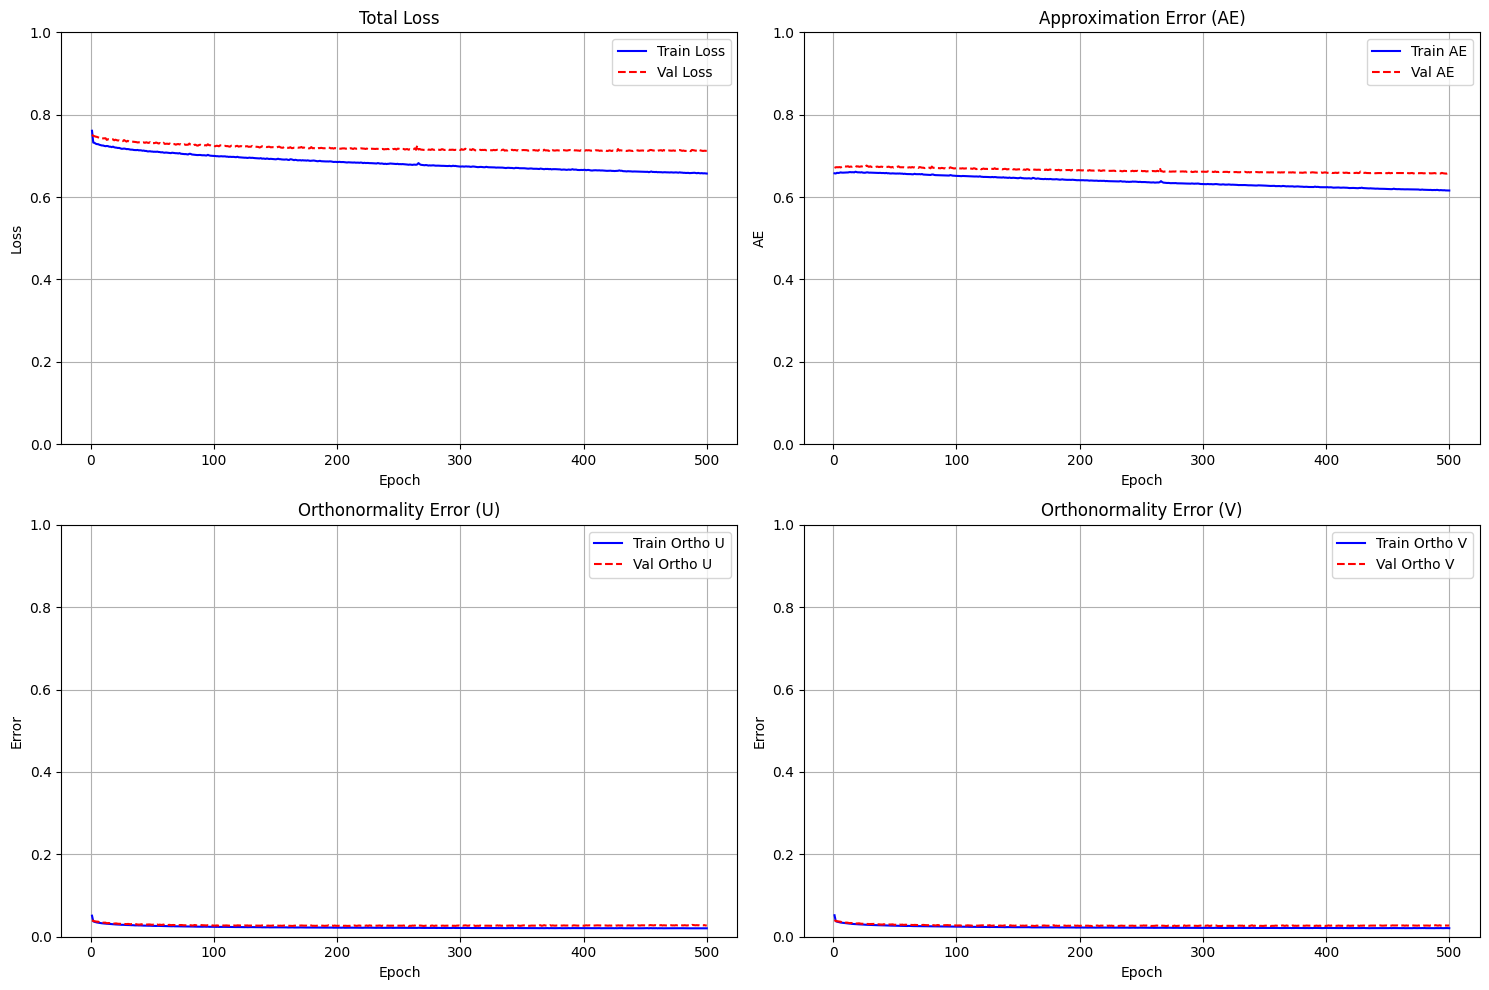

In [15]:
def plot_training_history(history):
    """Plot training and validation metrics over epochs"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r--', label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set y-axis limit to 0-1

    # AE
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_ae'], 'b-', label='Train AE')
    plt.plot(epochs, history['val_ae'], 'r--', label='Val AE')
    plt.title('Approximation Error (AE)')
    plt.xlabel('Epoch')
    plt.ylabel('AE')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set y-axis limit to 0-1

    # Ortho U
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_ortho_u'], 'b-', label='Train Ortho U')
    plt.plot(epochs, history['val_ortho_u'], 'r--', label='Val Ortho U')
    plt.title('Orthonormality Error (U)')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set y-axis limit to 0-1

    # Ortho V
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_ortho_v'], 'b-', label='Train Ortho V')
    plt.plot(epochs, history['val_ortho_v'], 'r--', label='Val Ortho V')
    plt.title('Orthonormality Error (V)')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set y-axis limit to 0-1
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

# Plot history
plot_training_history(history)

In [16]:
# Create test loaders using your original function
test_loaders = {}
for scenario in [1, 2, 3, 4]:
    dataset = create_test_dataset(
        data_dir="./CompetitionData2", 
        round=2, 
        scenarios=[scenario]
    )
    test_loaders[f"test_{scenario}"] = DataLoader(
        dataset, 
        batch_size=128, 
        shuffle=False
    )

# Verify one batch
H_input, H_input_cmplx = next(iter(test_loaders[f"test_{1}"]))
print("\n✅ Test dataloader created successfully!")
print("H_input shape:", H_input.shape)  # [128, 2, 64, 64]
print("H_input shape:", H_input_cmplx.shape, '\n')  # [128, 64, 64]

# Create test loaders using your original function
test_loaders = {}
for scenario in [1, 2, 3, 4]:
    dataset = create_test_dataset(
        data_dir="./CompetitionData2", 
        round=2, 
        scenarios=[scenario]
    )
    test_loaders[f"test_{scenario}"] = DataLoader(
        dataset, 
        batch_size=128, 
        shuffle=False
    )

if test_loaders is not None:
    test_results = evaluate_test_metrics(
        model, test_loaders, device, 
        lambda1=1, 
        lambda2=1
    )
    for name, metrics in test_results.items():
        print('\n')
        print(f"{name.capitalize()} Loss: {metrics['loss']:.4f} | AE: {metrics['ae']:.4f} | "
            f"Ortho U: {metrics['ortho_u']:.4f}, V: {metrics['ortho_v']:.4f}")

Scenario 1: 300 test samples indexed
Total indexed test samples: 300
Scenario 2: 300 test samples indexed
Total indexed test samples: 300
Scenario 3: 300 test samples indexed
Total indexed test samples: 300
Scenario 4: 300 test samples indexed
Total indexed test samples: 300

✅ Test dataloader created successfully!
H_input shape: torch.Size([128, 2, 128, 128])
H_input shape: torch.Size([128, 128, 128]) 

Scenario 1: 300 test samples indexed
Total indexed test samples: 300
Scenario 2: 300 test samples indexed
Total indexed test samples: 300
Scenario 3: 300 test samples indexed
Total indexed test samples: 300
Scenario 4: 300 test samples indexed
Total indexed test samples: 300


Test_1 Loss: 0.5332 | AE: 0.4737 | Ortho U: 0.0294, V: 0.0301


Test_2 Loss: 0.8182 | AE: 0.7581 | Ortho U: 0.0299, V: 0.0301


Test_3 Loss: 0.5643 | AE: 0.5042 | Ortho U: 0.0302, V: 0.0299


Test_4 Loss: 0.9507 | AE: 0.9014 | Ortho U: 0.0252, V: 0.0241


#### 11. Visualize the test matrixes

Visualizing random samples...


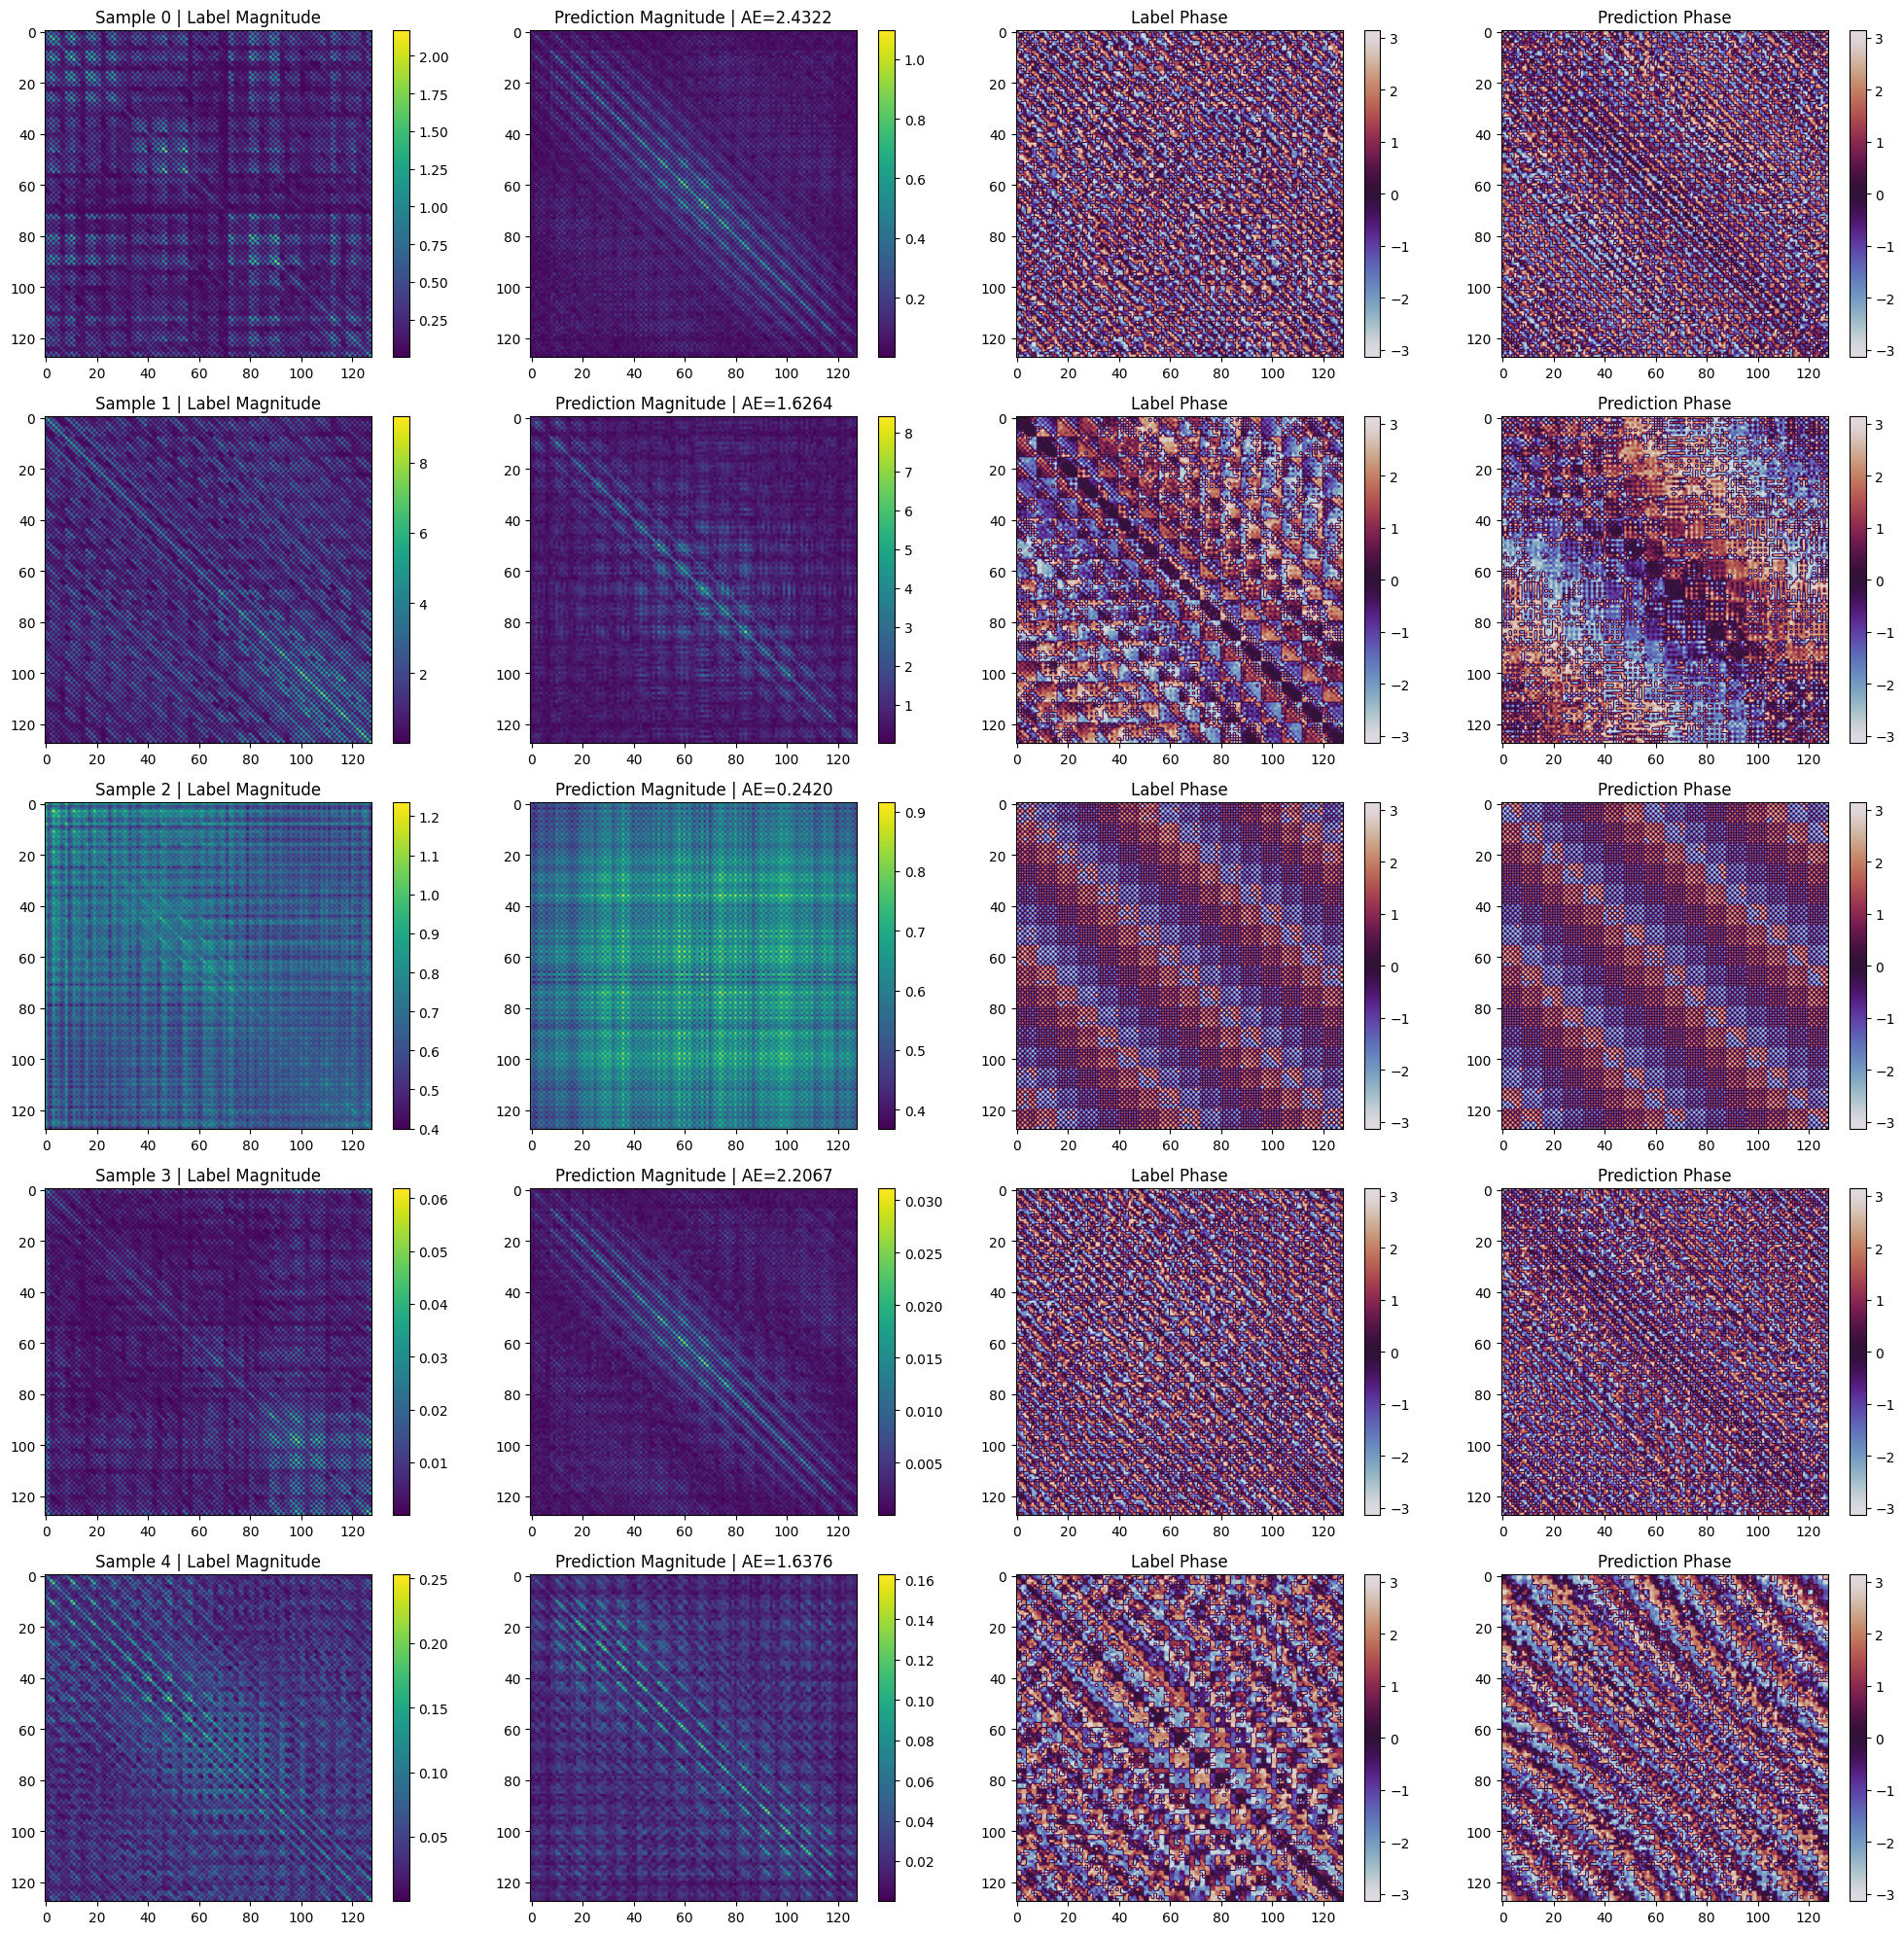

In [17]:
def visualize_reconstruction(model, test_loader, device, bad_samples=None, num_samples=5):
    """Visualize reconstruction quality for selected samples"""
    model.eval()
    model.to(device)
    
    # Get a batch of data
    H_input, H_input_cmplx = next(iter(test_loader))
    H_input = H_input.to(device)
    H_input_cmplx = H_input_cmplx.to(device)
    
    # Run through model
    with torch.no_grad():
        sigma, U, V = model(H_input)
        
        # Convert U and V to complex tensors for reconstruction
        # U: [B, M, k, 2] -> [B, M, k] complex
        U_complex = torch.complex(U[..., 0], U[..., 1])
        # V: [B, N, k, 2] -> [B, N, k] complex
        V_complex = torch.complex(V[..., 0], V[..., 1])
        
        sigma_complex = torch.complex(sigma, torch.zeros_like(sigma))  # [B, k] complex
        Sigma = torch.diag_embed(sigma_complex)                        # [B, k, k] complex
        # Reconstruct: H_pred = U @ diag(sigma) @ V^H

        Vh = torch.conj(V_complex).transpose(-1, -2)  # [B, k, N]
        H_pred = torch.matmul(U_complex, torch.matmul(Sigma, Vh))  # [B, M, N]
    
    # Convert to numpy for visualization
    H_input_cmplx = H_input_cmplx.cpu().numpy()
    H_pred_np = H_pred.cpu().numpy()
    
    plt.figure(figsize=(20, 4 * num_samples))
    
    for i in range(num_samples):
        idx = i if bad_samples is None else bad_samples[i]
        
        # Magnitude
        plt.subplot(num_samples, 4, 4*i+1)
        plt.imshow(np.abs(H_input_cmplx[idx]), cmap='viridis')
        plt.colorbar()
        plt.title(f"Sample {idx} | Label Magnitude")
        
        plt.subplot(num_samples, 4, 4*i+2)
        plt.imshow(np.abs(H_pred_np[idx]), cmap='viridis')
        plt.colorbar()
        ae = np.linalg.norm(H_input_cmplx[idx] - H_pred_np[idx], 'fro') / np.linalg.norm(H_pred_np[idx], 'fro')
        plt.title(f"Prediction Magnitude | AE={ae:.4f}")
        
        # Phase
        plt.subplot(num_samples, 4, 4*i+3)
        plt.imshow(np.angle(H_input_cmplx[idx]), cmap='twilight', vmin=-np.pi, vmax=np.pi)
        plt.colorbar()
        plt.title("Label Phase")
        
        plt.subplot(num_samples, 4, 4*i+4)
        plt.imshow(np.angle(H_pred_np[idx]), cmap='twilight', vmin=-np.pi, vmax=np.pi)
        plt.colorbar()
        plt.title("Prediction Phase")
    
    plt.tight_layout()
    # plt.savefig('reconstruction_comparison.png', dpi=300)
    plt.show()

print("Visualizing random samples...")
visualize_reconstruction(model, train_loader, device, num_samples=5)

#### 12. Generate the submission file

In [19]:
def generate_submission(model, test_loader, device, output_path="1.npz"):
    """
    Generate the submission file in the required format
    
    Args:
        model: Trained SVDCNN model
        test_loader: DataLoader for test data
        device: Device to run inference on
        output_path: Path to save the .npz file
    
    Returns:
        C: Mega MACs value
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Storage for results
    all_sigma = []
    all_U = []
    all_V = []
    
    # Run inference on test data
    with torch.no_grad():
        for H_input, _ in test_loader:  # No labels for test data
            H_input = H_input.to(device)
            sigma, U, V = model(H_input)
            
            all_sigma.append(abs(sigma.cpu()))
            all_U.append(U.cpu())
            all_V.append(V.cpu())
    
    # Concatenate results
    sigma_all = torch.cat(all_sigma, dim=0).numpy()  # [Nsamp, r]
    U_all = torch.cat(all_U, dim=0).numpy()  # [Nsamp, M, r, Q]
    V_all = torch.cat(all_V, dim=0).numpy()  # [Nsamp, N, r, Q]
    
    # Verify shapes match competition requirements
    N_samp, M, r, Q = U_all.shape
    _, N, _, _ = V_all.shape
    
    print("\n✅ Verifying submission shapes:")
    print(f"U shape: {U_all.shape} | Expected: ({N_samp}, {M}, {r}, {Q})")
    print(f"S shape: {sigma_all.shape} | Expected: ({N_samp}, {r})")
    print(f"V shape: {V_all.shape} | Expected: ({N_samp}, {N}, {r}, {Q})")
    
    dummy_input = torch.randn(1, 2, 64, 64).to(device)
    C = get_avg_flops(model, dummy_input)
    
    # Save with correct format
    np.savez(
        output_path,
        U=U_all,
        S=sigma_all,
        V=V_all,
        C=np.float32(C)
    )
    
    print(f"\n✅ Submission saved to {output_path}")
    print(f"U shape: {U_all.shape}")
    print(f"S shape: {sigma_all.shape}")
    print(f"V shape: {V_all.shape}")
    print(f"C value (Mega MACs): {C:.4f}")
    
    return C

In [20]:
for i in [1,2,3,4]:
    print(f"\n\n=== Generating submission for scenario {i} ===")
    
    # 1. Create test dataset and loader
    test_dataset = create_test_dataset(
        data_dir="./CompetitionData2",
        round=2,
        scenarios=[i]  # Use scenario i
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=128,
        shuffle=False,  # Critical: maintain original order
        num_workers=0
    )

    # 2. Generate submission file
    C = generate_submission(
        model=model,
        test_loader=test_loader,
        device=device,
        output_path=f"{i}.npz"
    )

    # 3. Verify submission format
    submission = np.load(f"{i}.npz")
    print("\n✅ Final submission verification:")
    print(f"U shape: {submission['U'].shape}")
    print(f"S shape: {submission['S'].shape}")
    print(f"V shape: {submission['V'].shape}")
    print(f"C value: {submission['C']} (Mega MACs)")    




=== Generating submission for scenario 1 ===
Scenario 1: 300 test samples indexed
Total indexed test samples: 300

✅ Verifying submission shapes:
U shape: (300, 128, 64, 2) | Expected: (300, 128, 64, 2)
S shape: (300, 64) | Expected: (300, 64)
V shape: (300, 128, 64, 2) | Expected: (300, 128, 64, 2)

✅ Submission saved to 1.npz
U shape: (300, 128, 64, 2)
S shape: (300, 64)
V shape: (300, 128, 64, 2)
C value (Mega MACs): 17.7789

✅ Final submission verification:
U shape: (300, 128, 64, 2)
S shape: (300, 64)
V shape: (300, 128, 64, 2)
C value: 17.778879165649414 (Mega MACs)


=== Generating submission for scenario 2 ===
Scenario 2: 300 test samples indexed
Total indexed test samples: 300

✅ Verifying submission shapes:
U shape: (300, 128, 64, 2) | Expected: (300, 128, 64, 2)
S shape: (300, 64) | Expected: (300, 64)
V shape: (300, 128, 64, 2) | Expected: (300, 128, 64, 2)

✅ Submission saved to 2.npz
U shape: (300, 128, 64, 2)
S shape: (300, 64)
V shape: (300, 128, 64, 2)
C value (Mega 

In [21]:
import zipfile
import os
import numpy as np
import torch

def create_final_submission_zip(output_zip="submission.zip"):
    """
    Creates a ZIP file containing all required submission files for Huawei Tech Arena 2025
    
    This includes:
    - 1.npz: Results for scenario 1
    - 2.npz: Results for scenario 2
    - 3.npz: Results for scenario 3
    - 4.npz: Results for scenario 4
    - model_definition.py: Model definition and training code
    - model_weights.pth: Trained model weights
    
    Args:
        output_zip: Name of the output ZIP file
    
    Returns:
        str: Path to the created ZIP file
    """
    print("🚀 Starting final submission package creation for Huawei Tech Arena 2025")
    
    # Verify all required files exist
    required_files = [
        "1.npz",
        "2.npz",
        "3.npz",
        "4.npz",
        "model_definition.py",
        "model_weights.pth"
    ]
    
    missing_files = [f for f in required_files if not os.path.exists(f)]
    if missing_files:
        raise FileNotFoundError(
            f"Missing required submission files: {', '.join(missing_files)}\n"
            "Please ensure all 5 required files are in the current directory.\n"
            "You need 4 .npz files (1.npz, 2.npz, 3.npz, 4.npz) + model files."
        )
    
    # Create ZIP file with all required files
    print(f"\n📦 Creating ZIP submission package: {output_zip}")
    
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in required_files:
            zipf.write(file)
            print(f"   ✓ Added {file} to ZIP package")
    
    # Verify ZIP contents
    print("\n🔍 Verifying ZIP contents:")
    with zipfile.ZipFile(output_zip, 'r') as zipf:
        for file in zipf.namelist():
            info = zipf.getinfo(file)
            print(f"   • {file} ({info.file_size/1024:.2f} KB)")
    
    # Verify all .npz files have correct format
    print("\n🔍 Verifying .npz file formats...")
    for i in range(1, 5):
        npz_path = f"{i}.npz"
        print(f"\n📊 Verifying {npz_path}:")
        
        submission = np.load(npz_path)
        
        # Check required components
        required_components = ['U', 'S', 'V', 'C']
        for component in required_components:
            if component not in submission:
                raise ValueError(f"Missing {component} in {npz_path}")
            print(f"   ✓ Found {component} in {npz_path}")
        
        # Check shapes
        print(f"   U shape: {submission['U'].shape} (should be [Nsamp, 128, 64, 2])")
        print(f"   S shape: {submission['S'].shape} (should be [Nsamp, 64])")
        print(f"   V shape: {submission['V'].shape} (should be [Nsamp, 128, 64, 2])")
        print(f"   C value: {submission['C']} (Mega MACs)")
        
        # Verify all singular values are positive
        if np.all(submission['S'] > 0):
            print("   ✓ All singular values are positive")
        else:
            print("   ⚠️ WARNING: Some singular values are not positive!")
    
    print(f"\n🎉 Final submission package created: {output_zip}")
    print("➡️ You can now upload this ZIP file to the competition platform")
    print("\n📌 This package contains all 5 required components for the competition:")
    print("   - 1.npz: Algorithm output for scenario 1")
    print("   - 2.npz: Algorithm output for scenario 2")
    print("   - 3.npz: Algorithm output for scenario 3")
    print("   - 4.npz: Algorithm output for scenario 4")
    print("   - model_definition.py: Complete model definition")
    print("   - model_weights.pth: Trained model weights")
    
    return output_zip

# Create the final submission ZIP
create_final_submission_zip(output_zip="Huawei_Tech_Arena_2025_Submission.zip")

🚀 Starting final submission package creation for Huawei Tech Arena 2025

📦 Creating ZIP submission package: Huawei_Tech_Arena_2025_Submission.zip
   ✓ Added 1.npz to ZIP package
   ✓ Added 2.npz to ZIP package
   ✓ Added 3.npz to ZIP package
   ✓ Added 4.npz to ZIP package
   ✓ Added model_definition.py to ZIP package
   ✓ Added model_weights.pth to ZIP package

🔍 Verifying ZIP contents:
   • 1.npz (38475.94 KB)
   • 2.npz (38475.94 KB)
   • 3.npz (38475.94 KB)
   • 4.npz (38475.94 KB)
   • model_definition.py (6.02 KB)
   • model_weights.pth (84450.10 KB)

🔍 Verifying .npz file formats...

📊 Verifying 1.npz:
   ✓ Found U in 1.npz
   ✓ Found S in 1.npz
   ✓ Found V in 1.npz
   ✓ Found C in 1.npz
   U shape: (300, 128, 64, 2) (should be [Nsamp, 128, 64, 2])
   S shape: (300, 64) (should be [Nsamp, 64])
   V shape: (300, 128, 64, 2) (should be [Nsamp, 128, 64, 2])
   C value: 17.778879165649414 (Mega MACs)
   ✓ All singular values are positive

📊 Verifying 2.npz:
   ✓ Found U in 2.npz
  

'Huawei_Tech_Arena_2025_Submission.zip'